# Import The Packages Needed


---



In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor
import random
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans

# Read And Examine the Files

*   Check data types
*   Check Outliers in Numeric Data
*   Check Unique Values



In [2]:
#The training files are saved as zip files. I am decompressing the files first then reading them into dataframes. 

df = pd.read_csv('AB_NYC_2019.csv')
#inspect the training_features dataframe
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [ ]:
df.reviews_per_month.value_counts()

In [3]:
#checking if there are any null values in the dataframe
df.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [4]:
#take out the rows that are empty in these columns
df.fillna({'reviews_per_month':0}, inplace=True)
df.fillna({'host_name':"NoName"}, inplace=True)
df.fillna({'last_review':"NotReviewed"}, inplace=True)
df = df[df['name'].notna()]

In [5]:
df.isnull().sum()

id                                0
name                              0
host_id                           0
host_name                         0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [6]:
#describe the data
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.887900e+04,4.887900e+04,48879.000000,48879.000000,48879.000000,48879.000000,48879.000000,48879.000000,48879.000000,48879.000000
mean,1.902062e+07,6.763013e+07,40.728945,-73.952168,152.722355,7.011027,23.281205,1.091248,7.145891,112.788989
std,1.098282e+07,7.862070e+07,0.054529,0.046160,240.186804,20.016000,44.556149,1.597433,32.957738,131.613322
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,9.474248e+06,7.816856e+06,40.690090,-73.983070,69.000000,1.000000,1.000000,0.040000,1.000000,0.000000
50%,1.968643e+07,3.079133e+07,40.723080,-73.955680,106.000000,3.000000,5.000000,0.370000,1.000000,45.000000
75%,2.915334e+07,1.074344e+08,40.763110,-73.936280,175.000000,5.000000,24.000000,1.580000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [7]:
#look for the sum of all the values that are empty in the dataframe
df.shape

(48879, 16)

In [ ]:
#handle longitude and latitude data

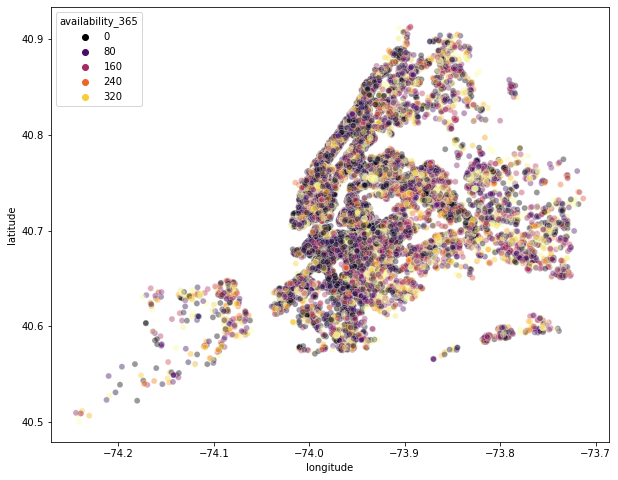

In [31]:
plt.figure(figsize = (10,8))
sns.scatterplot(x=df['longitude'], hue = df['availability_365'], y=df['latitude'],c=df['price'],cmap=plt.get_cmap('jet'), palette = 'inferno',alpha=0.4)
plt.show()

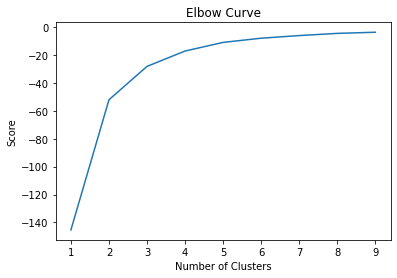

In [32]:
K_clusters = range(1,10)

kmeans = [KMeans(n_clusters=i) for i in K_clusters]

Y_axis = df[['latitude']]
X_axis = df[['longitude']]

score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]

plt.plot(K_clusters, score)
plt.xlabel("Number of Clusters")
plt.ylabel('Score')

plt.title("Elbow Curve")
plt.show()

In [47]:
df.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [33]:
location = df[['id','longitude','latitude']]

In [34]:
kmeans = KMeans(n_clusters = 5, init = 'k-means++')
kmeans.fit(location)

df['location_cluster'] = kmeans.fit_predict(location)

In [35]:
df.location_cluster.value_counts()

2    10977
1    10190
4     9948
3     8979
0     8785
Name: location_cluster, dtype: int64

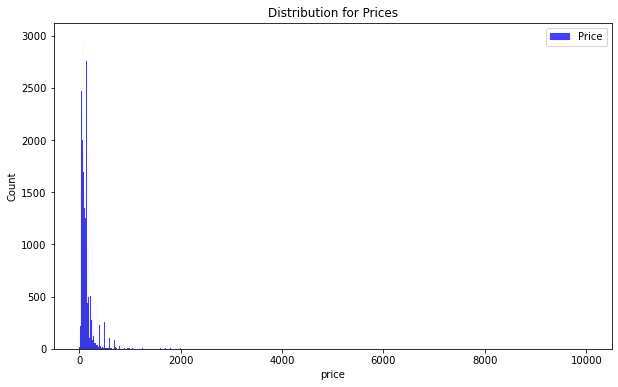

In [36]:
#Check the distribution of prices

plt.figure(figsize=(10,6))
plt.title("Distribution for Prices")
ax = sns.histplot(x = df['price'], color= 'b', label='Price')
plt.legend()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


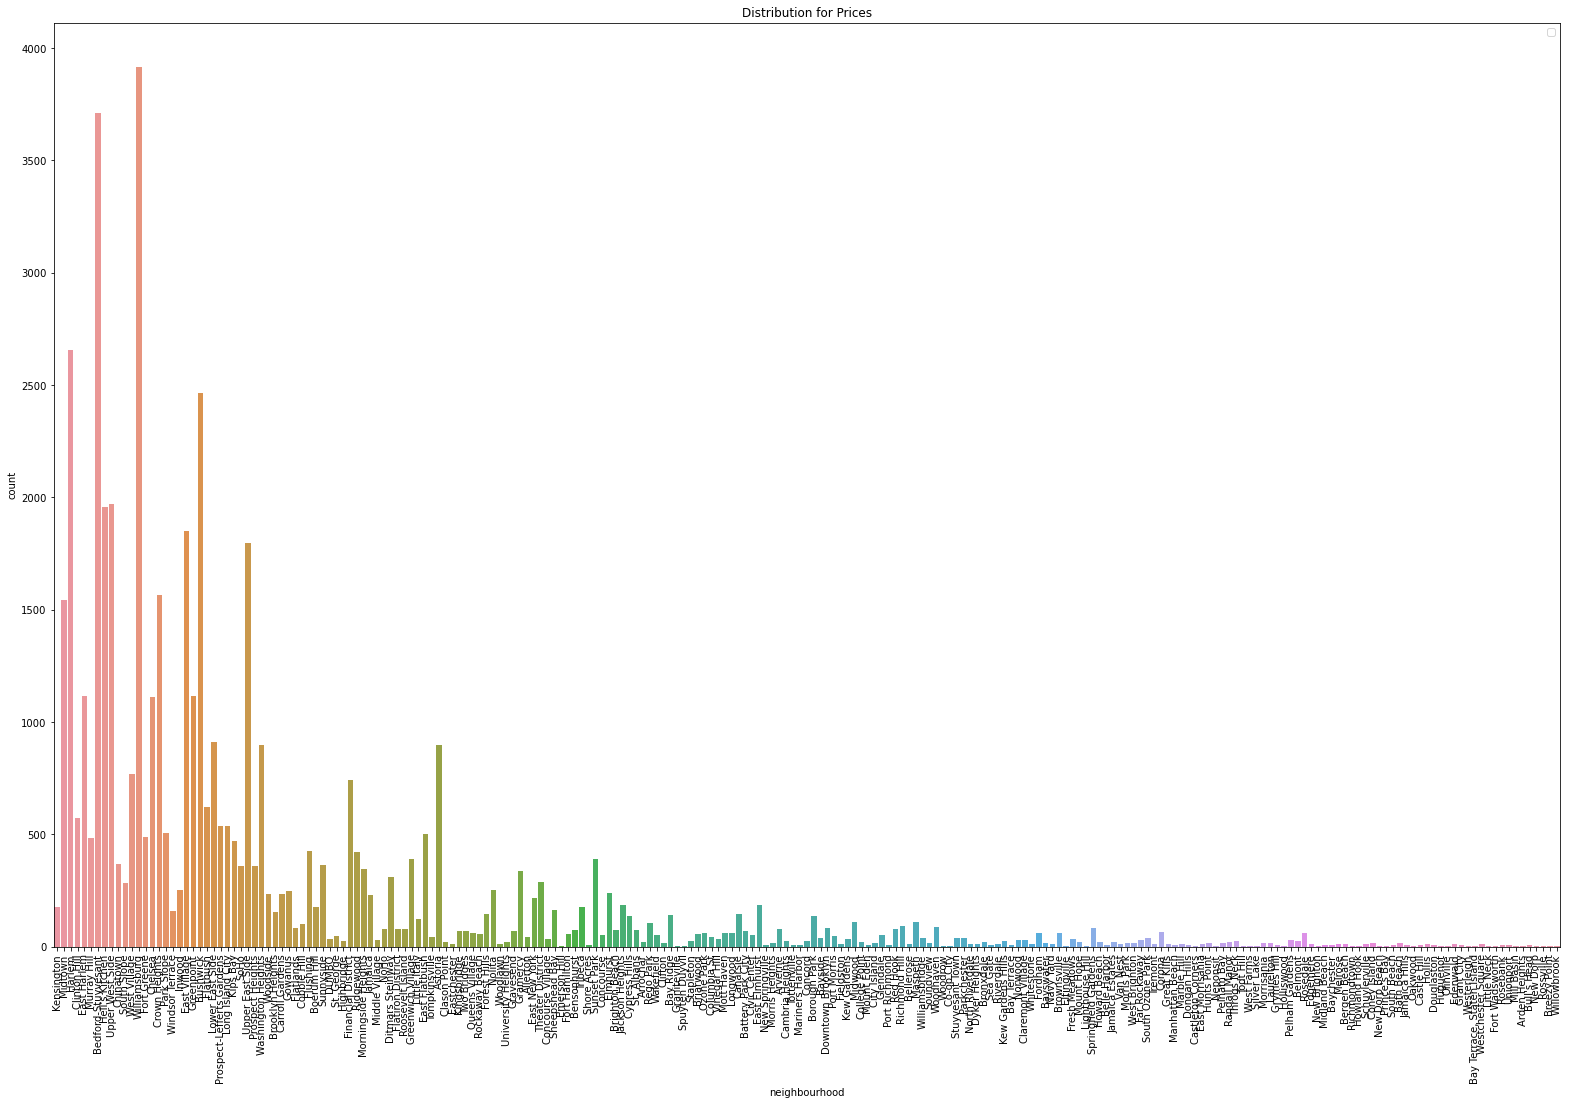

In [38]:
plt.figure(figsize=(27,17))
plt.title("Distribution for Prices")
ax = sns.countplot(x = df['neighbourhood'])
plt.legend()
plt.xticks(rotation = 90)
plt.show()



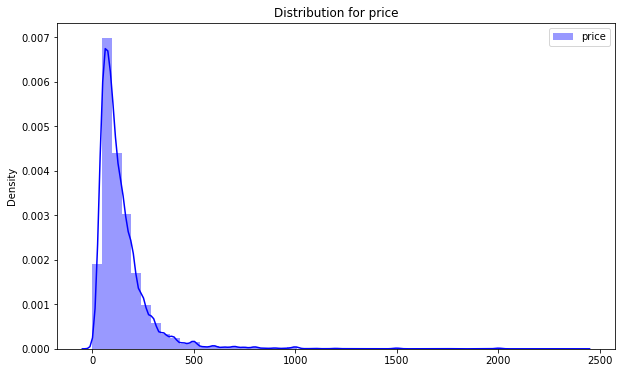

In [40]:
#Check the distribution of prices without outliers

def distplot(feature, frame):
    plt.figure(figsize=(10,6))
    plt.title("Distribution for {}".format(feature))
    ax0 = sns.distplot(x = frame[frame['price'] <2500][feature], color= 'b', label='price')
    plt.legend()
    plt.show()
    
distplot('price', df)

In [41]:
#Remove the Outliers from the price column
from scipy import stats

cols = ['price'] # one or more

Q1 = df[cols].quantile(0.25)
Q3 = df[cols].quantile(0.75)
IQR = Q3 - Q1

df = df[~((df[cols] < (Q1 - 1.5 * IQR)) |(df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [42]:
#new shape after removing price outliers
df.shape

(45908, 17)

In [ ]:
#df.drop(df[df.availability_365 ==17].index)

# More Data Visualization


---
**All graphs are only a sample size of the total number of rows

*   Countplot for Categorical Data
*   Scatterplot with numeric features and price
*   Heatmap for all numeric features








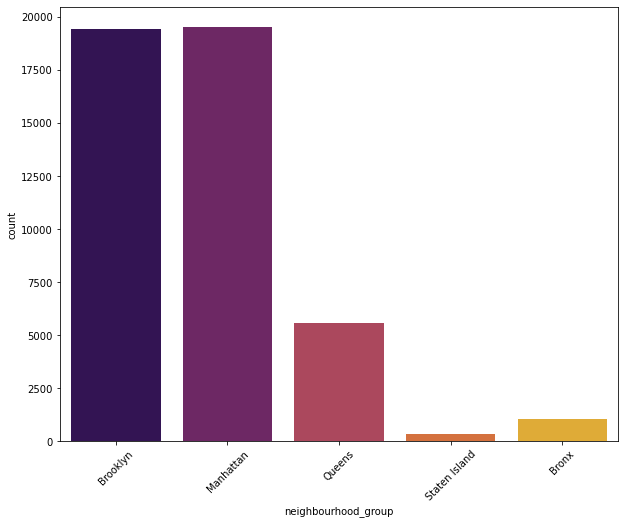

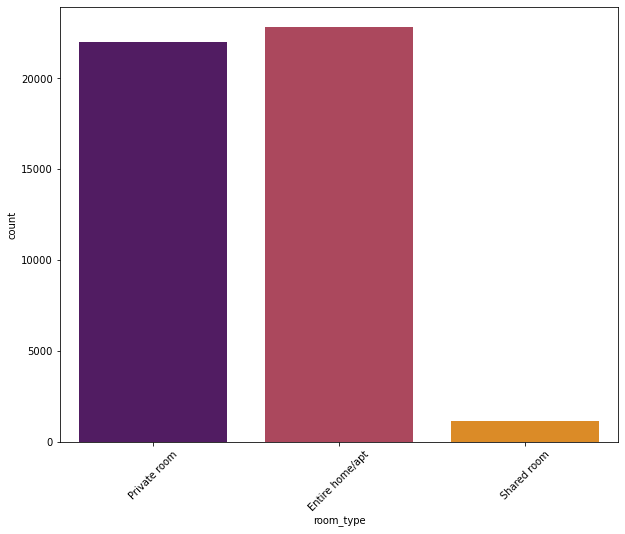

In [43]:
#visualize neighbourhood group and room type categories
cols = ['neighbourhood_group', 'room_type']
for column in df:
    if column in cols:
        plt.figure(figsize=(10,8))
        ax = sns.countplot(x = df[column], palette = 'inferno')
        plt.xticks(rotation = 45)
        plt.show()

In [44]:
df['minimum_nights'].value_counts().head(30)

1      12059
2      11080
3       7373
30      3493
4       3063
5       2820
7       1950
6        679
14       539
10       462
29       327
15       272
20       215
31       189
28       173
21       133
8        127
60        98
90        95
12        88
25        80
9         79
13        53
180       35
45        32
11        31
18        28
120       25
365       23
16        17
Name: minimum_nights, dtype: int64

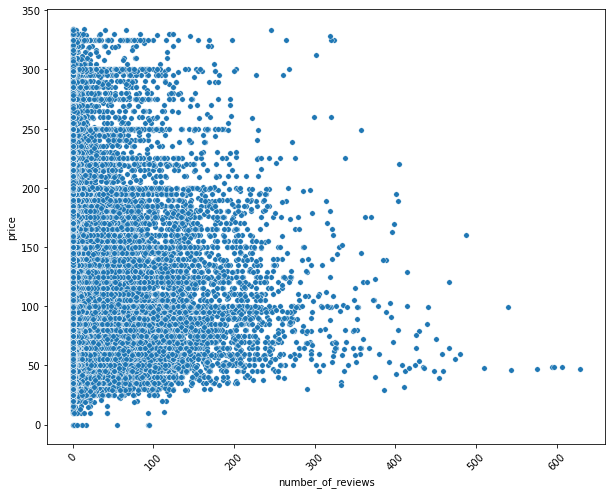

In [45]:
#explore linear reliationship bewtween the numeric values and price
plt.figure(figsize = (10,8))
sns.scatterplot(x=df['number_of_reviews'], y = df['price'], s = 30)
plt.xticks(rotation = 45)
plt.show()

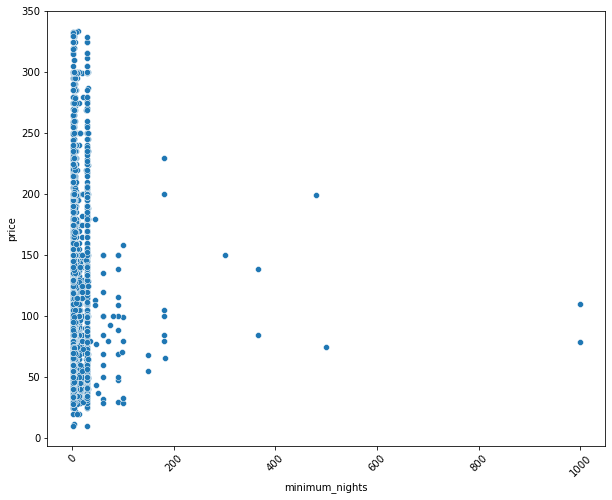

In [46]:
#check the scatterplot of the room types and prices
plt.figure(figsize = (10,8))
sns.scatterplot(x=df['minimum_nights'].sample(5000), y=df['price'])
plt.xticks(rotation = 45)
plt.show()

In [47]:
df['minimum_nights'].describe()

count    45908.000000
mean         6.939509
std         19.860879
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max       1250.000000
Name: minimum_nights, dtype: float64

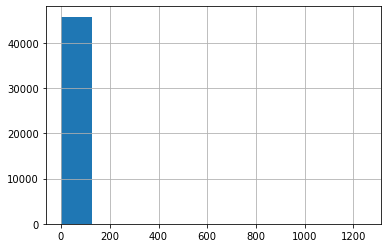

In [48]:
df['minimum_nights'].hist()
plt.show()


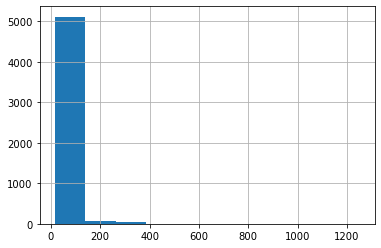

In [49]:
df["minimum_nights"][df["minimum_nights"]>15].hist()
plt.show()

In [50]:
#Check how many listings have over 30 minimum nights requirement
df["minimum_nights"][df["minimum_nights"]>30]

6         45
14        90
36        60
81        31
106       90
        ... 
48325     60
48368     60
48446    365
48752     32
48784     45
Name: minimum_nights, Length: 686, dtype: int64

In [51]:
df.loc[(df.minimum_nights >30),"minimum_nights"]=30

In [52]:
#Set the minimum nights to 30 maximum value
df = df[df["minimum_nights"] <31].copy()

In [53]:
#Get the length of the listings' names
df["name_length"]= df['name'].map(str).apply(len)

<AxesSubplot:xlabel='name_length', ylabel='price'>

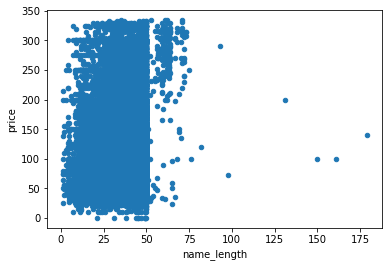

In [54]:
df.plot.scatter(x="name_length", y ="price" )

<AxesSubplot:xlabel='name_length', ylabel='price'>

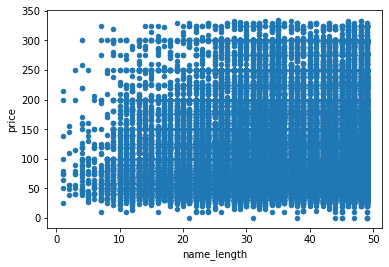

In [55]:
#Remove names that have over 50 as length
#Indeed we see a lnear progression
df[df["name_length"]<50].plot.scatter(x="name_length", y ="price")

In [56]:
df['name_length'].value_counts()

50     3690
35     3204
49     2830
34     2454
48     2229
       ... 
179       1
150       1
93        1
98        1
76        1
Name: name_length, Length: 81, dtype: int64

In [57]:
#drop the values that are over 125 as they appear to be outliers
name_col = ['name_length'] # one or more

Q1a = df[name_col].quantile(0.25)
Q3a = df[name_col].quantile(0.75)
IQRa = Q3a - Q1a

df = df[~((df[name_col] < (Q1a - 1.5 * IQRa)) |(df[name_col] > (Q3a + 1.5 * IQRa))).any(axis=1)]

In [58]:
#Remove reviews per month that are outliers
df['reviews_per_month'] = df[df['reviews_per_month'] < 17.5]['reviews_per_month']

/var/folders/vq/my5yd2dj7zjb5l9g3_64pwr80000gn/T/ipykernel_16573/3355814640.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['reviews_per_month'] = df[df['reviews_per_month'] < 17.5]['reviews_per_month']


In [59]:
df['all_year_avail'] = df['availability_365']>353
df['low_avail'] = df['availability_365']< 12
df['no_reviews'] = df['reviews_per_month']==0

/var/folders/vq/my5yd2dj7zjb5l9g3_64pwr80000gn/T/ipykernel_16573/4141838313.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['all_year_avail'] = df['availability_365']>353
/var/folders/vq/my5yd2dj7zjb5l9g3_64pwr80000gn/T/ipykernel_16573/4141838313.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['low_avail'] = df['availability_365']< 12
/var/folders/vq/my5yd2dj7zjb5l9g3_64pwr80000gn/T/ipykernel_16573/4141838313.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [60]:
df.head(10)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,location_cluster,name_length,all_year_avail,low_avail,no_reviews
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,...,9,2018-10-19,0.21,6,365,1,34,True,False,False
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,...,45,2019-05-21,0.38,2,355,1,21,True,False,False
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,...,0,NotReviewed,0.00,1,365,1,35,True,False,True
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,...,270,2019-07-05,4.64,1,194,1,31,False,False,False
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,...,9,2018-11-19,0.10,1,0,1,48,False,True,False
5,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,...,74,2019-06-22,0.59,1,129,1,41,False,False,False
6,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,...,49,2017-10-05,0.40,1,0,1,15,False,True,False
7,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,79,...,430,2019-06-24,3.47,1,220,1,32,False,False,False
8,5203,Cozy Clean Guest Room - Family Apt,7490,MaryEllen,Manhattan,Upper West Side,40.80178,-73.96723,Private room,79,...,118,2017-07-21,0.99,1,0,1,34,False,True,False
9,5238,Cute & Cozy Lower East Side 1 bdrm,7549,Ben,Manhattan,Chinatown,40.71344,-73.99037,Entire home/apt,150,...,160,2019-06-09,1.33,4,188,1,34,False,False,False


In [61]:
#see the number of values in neighbourhood
neigh_count = df['neighbourhood'].value_counts()
select_neigh = neigh_count[neigh_count > 500].index.values

In [62]:
dfnh =df.groupby("neighbourhood").filter(lambda x: x['neighbourhood'].count() > 100)

In [63]:
len(dfnh["neighbourhood"])

41884

In [64]:
dfnh.neighbourhood.unique()

array(['Kensington', 'Midtown', 'Harlem', 'Clinton Hill', 'East Harlem',
       'Murray Hill', 'Bedford-Stuyvesant', "Hell's Kitchen",
       'Upper West Side', 'Chinatown', 'South Slope', 'West Village',
       'Williamsburg', 'Fort Greene', 'Chelsea', 'Crown Heights',
       'Park Slope', 'Windsor Terrace', 'Inwood', 'East Village',
       'Greenpoint', 'Bushwick', 'Flatbush', 'Lower East Side',
       'Prospect-Lefferts Gardens', 'Long Island City', 'Kips Bay',
       'SoHo', 'Upper East Side', 'Prospect Heights',
       'Washington Heights', 'Woodside', 'Carroll Gardens', 'Gowanus',
       'Flushing', 'Sunnyside', 'Financial District',
       'Morningside Heights', 'Jamaica', 'Ridgewood', 'Ditmars Steinway',
       'Greenwich Village', 'Little Italy', 'East Flatbush', 'Astoria',
       'Boerum Hill', 'Brooklyn Heights', 'Forest Hills', 'Nolita',
       'East New York', 'Theater District', 'Sheepshead Bay', 'Tribeca',
       'Sunset Park', 'Gramercy', 'Elmhurst', 'Jackson Heights',


In [65]:
len(select_neigh)

22

In [ ]:
#remove the neighborhoods that had really low numbers of listings
# df = df[df['neighbourhood'].isin(select_neigh)]

In [66]:
for idx, row in dfnh.iterrows():
    if dfnh.loc[idx, 'neighbourhood'] not in select_neigh:
        dfnh.loc[idx, 'neighbourhood'] = 'other'

In [ ]:
#replace low frequency neighbourhood group names with other
# neigh_group_count = df['neighbourhood_group'].value_counts()
# low_neigh_group = neigh_group_count[neigh_group_count < 2000].index.values

In [ ]:
# for idx, row in df1.iterrows():
#     if df1.loc[idx, 'neighbourhood_group'] in low_neigh_group:
#         df1.loc[idx, 'neighbourhood_group'] = 'other'

In [67]:
#get the categorical dummies without neighborhood first
df_encoded = pd.get_dummies(dfnh, columns = ['neighbourhood_group', 'room_type','neighbourhood','all_year_avail','low_avail','no_reviews','location_cluster'])
# 'all_year_avail','low_avail','no_reviews'
df_encoded.head()

,id,name,host_id,host_name,latitude,longitude,price,minimum_nights,number_of_reviews,last_review,...,all_year_avail_True,low_avail_False,low_avail_True,no_reviews_False,no_reviews_True,location_cluster_0,location_cluster_1,location_cluster_2,location_cluster_3,location_cluster_4
0,2539,Clean & quiet apt home by the park,2787,John,40.64749,-73.97237,149,1,9,2018-10-19,...,1,1,0,1,0,0,1,0,0,0
1,2595,Skylit Midtown Castle,2845,Jennifer,40.75362,-73.98377,225,1,45,2019-05-21,...,1,1,0,1,0,0,1,0,0,0
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,40.80902,-73.94190,150,3,0,NotReviewed,...,1,1,0,0,1,0,1,0,0,0
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,40.68514,-73.95976,89,1,270,2019-07-05,...,0,1,0,1,0,0,1,0,0,0
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,40.79851,-73.94399,80,10,9,2018-11-19,...,0,0,1,1,0,0,1,0,0,0


In [ ]:
# df_encoded['location'] = df_encoded['longitude']*df_encoded['latitude']
# df_encoded['longitude square'] = df_encoded['longitude']*df_encoded['longitude']
# df_encoded['latitude square'] = df_encoded['latitude']*df_encoded['latitude']

In [68]:
df_encoded = df_encoded[dfnh['reviews_per_month'].notna()]

,price,number_of_reviews,reviews_per_month,availability_365,calculated_host_listings_count,minimum_nights
price,1.000000,0.000311,0.008527,0.040519,0.193216,0.016843
number_of_reviews,0.000311,1.000000,0.411396,0.153355,-0.099052,-0.069881
reviews_per_month,0.008527,0.411396,1.000000,0.256010,-0.086331,-0.152688
availability_365,0.040519,0.153355,0.256010,1.000000,0.079998,-0.005551
calculated_host_listings_count,0.193216,-0.099052,-0.086331,0.079998,1.000000,0.012861
minimum_nights,0.016843,-0.069881,-0.152688,-0.005551,0.012861,1.000000


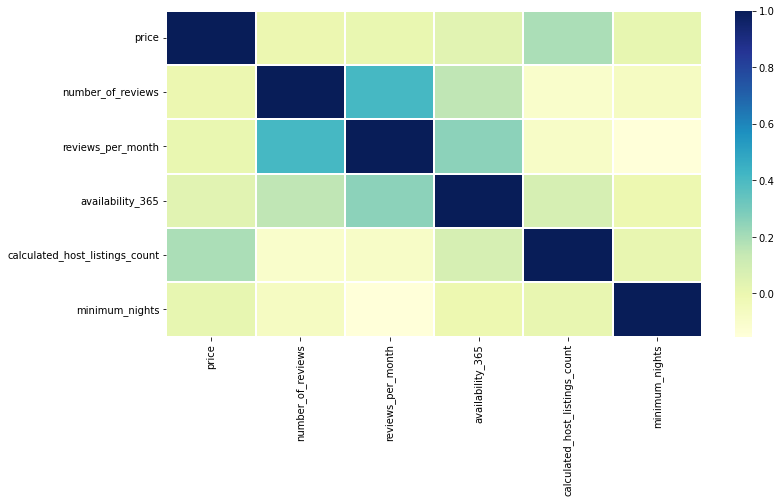

In [69]:
#plot the heatmap to check correlations amongst the variables
plt.figure(figsize=(12, 6))
corr = df_encoded[['price', 
           'number_of_reviews','reviews_per_month',
           'availability_365','calculated_host_listings_count','minimum_nights']].apply(lambda x: pd.factorize(x)[0]).corr()
display(corr)
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, linewidths=.2, cmap="YlGnBu")


In [70]:
#drop the irrelevant columns
df_encoded.drop(['name','id' ,
                 'host_id','host_name',
                 'last_review'],axis = 1, inplace = True)

In [71]:
X = df_encoded.loc[:, df_encoded.columns != 'price']

In [72]:
y = df_encoded['price']

In [73]:
#normalize the training data
norm_cols = ['availability_365','calculated_host_listings_count','name_length','minimum_nights',
             'reviews_per_month', 'number_of_reviews','number_of_reviews',
             'latitude','longitude']

In [40]:
X.head()

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,name_length,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,...,all_year_avail_True,low_avail_False,low_avail_True,no_reviews_False,no_reviews_True,location_cluster_0,location_cluster_1,location_cluster_2,location_cluster_3,location_cluster_4
0,40.64749,-73.97237,1,9,0.21,6,365,34,1,0,...,1,1,0,1,0,1,0,0,0,0
1,40.75362,-73.98377,1,45,0.38,2,355,21,0,1,...,1,1,0,1,0,1,0,0,0,0
2,40.80902,-73.94190,3,0,0.00,1,365,35,0,1,...,1,1,0,0,1,1,0,0,0,0
3,40.68514,-73.95976,1,270,4.64,1,194,31,1,0,...,0,1,0,1,0,1,0,0,0,0
4,40.79851,-73.94399,10,9,0.10,1,0,48,0,1,...,0,0,1,1,0,1,0,0,0,0


In [74]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
X[norm_cols] = scaler.fit_transform(X[norm_cols])

/var/folders/vq/my5yd2dj7zjb5l9g3_64pwr80000gn/T/ipykernel_16573/4197784338.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[norm_cols] = scaler.fit_transform(X[norm_cols])


In [75]:
#split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)


In [ ]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# X_train[norm_cols] = scaler.fit_transform(X_train[norm_cols])
# X_test[norm_cols] = scaler.fit_transform(X_test[norm_cols])

In [76]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression
from math import sqrt

cv = KFold(n_splits=10, random_state=0, shuffle=True)
classifier_pipeline = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=20))
y_pred = cross_val_predict(classifier_pipeline, X_train, y_train, cv=cv)
print("RMSE: " + str(round(sqrt(mean_squared_error(y_train,y_pred)),2)))
print("R_squared: " + str(round(r2_score(y_train,y_pred),2)))

RMSE: 47.42
R_squared: 0.51


In [ ]:
#find the vairables that have low variabilities and filter them out
#the dummy variables are not included
small = [X_train.var()<0.03]

In [ ]:
#check for the inclusion of features at different correlation values and the accuracy scores
vals = [0.03,0.02,0.01,0.005]
df_exp = df_encoded.drop(['reviews_per_month'],axis = 1)
for val in vals:
    features = abs(df_exp.corr()["price"][abs(df_exp.corr()["price"])>val].drop('price')).index.tolist()
    
    X_1 = df_exp.drop(['price'],axis = 1)
    X_1=X[features]
    
    print(features)

    y_pred = cross_val_predict(classifier_pipeline, X_1, y, cv=cv)
    print("RMSE: " + str(round(sqrt(mean_squared_error(y,y_pred)),2)))
    print("R_squared: " + str(round(r2_score(y,y_pred),2)))

In [ ]:
ls1 = ['minimum_nights', 'number_of_reviews', 'calculated_host_listings_count', 'availability_365', 'name_length', 'neighbourhood_group_Bronx', 'neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens', 'neighbourhood_group_Staten Island', 'room_type_Entire home/apt', 'room_type_Private room', 'room_type_Shared room', 'neighbourhood_Astoria', 'neighbourhood_Bedford-Stuyvesant', 'neighbourhood_Bushwick', 'neighbourhood_Chelsea', 'neighbourhood_Crown Heights', 'neighbourhood_East Harlem', 'neighbourhood_East Village', 'neighbourhood_Financial District', 'neighbourhood_Flatbush', 'neighbourhood_Harlem', "neighbourhood_Hell's Kitchen", 'neighbourhood_Long Island City', 'neighbourhood_Lower East Side', 'neighbourhood_Midtown', 'neighbourhood_Prospect-Lefferts Gardens', 'neighbourhood_Upper East Side', 'neighbourhood_Upper West Side', 'neighbourhood_Washington Heights', 'neighbourhood_West Village', 'neighbourhood_Williamsburg', 'neighbourhood_other']
ls2 = ['minimum_nights', 'calculated_host_listings_count', 'availability_365', 'name_length', 'neighbourhood_group_Bronx', 'neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens', 'neighbourhood_group_Staten Island', 'room_type_Entire home/apt', 'room_type_Private room', 'room_type_Shared room', 'neighbourhood_Astoria', 'neighbourhood_Bedford-Stuyvesant', 'neighbourhood_Bushwick', 'neighbourhood_Chelsea', 'neighbourhood_Crown Heights', 'neighbourhood_East Village', 'neighbourhood_Financial District', 'neighbourhood_Flatbush', 'neighbourhood_Harlem', "neighbourhood_Hell's Kitchen", 'neighbourhood_Lower East Side', 'neighbourhood_Midtown', 'neighbourhood_Prospect-Lefferts Gardens', 'neighbourhood_Upper East Side', 'neighbourhood_Upper West Side', 'neighbourhood_Washington Heights', 'neighbourhood_West Village', 'neighbourhood_other']

In [ ]:
for item in ls1:
    if item not in ls2:
        print(item)

In [ ]:
X.isna().sum()

In [77]:
model_l = LinearRegression()

model_l.fit(X_train, y_train)
y_pred_l = model_l.predict(X_train)


l_mae = MAE(y_train, y_pred_l)
print("Training Set MAE:%4f" % l_mae)
l_mse = MSE(y_test, model_l.predict(X_test))
print("MSE:%4f" % l_mse)
print("RMSE Score: ", np.sqrt(l_mse))
print("R2 Score: {:.4f}".format(r2_score(y_test, model_l.predict(X_test))))

Training Set MAE:34.153445
MSE:2238.013603
RMSE Score:  47.307648462899934
R2 Score: 0.5301


In [44]:
intercept = model_l.intercept_
features_importance = pd.DataFrame(model_l.coef_, X_train.columns, columns=['coefficient'])
features_importance.sort_values("coefficient", ascending = False)

,coefficient
room_type_Entire home/apt,59.632352
neighbourhood_Williamsburg,25.883855
neighbourhood_group_Manhattan,20.957148
neighbourhood_Midtown,19.392742
neighbourhood_Greenpoint,19.338484
neighbourhood_West Village,16.306313
neighbourhood_Clinton Hill,12.141012
neighbourhood_Chelsea,11.437483
neighbourhood_Hell's Kitchen,7.079898
low_avail_False,6.244497


In [45]:
from sklearn.linear_model import Lasso

regL1 = Lasso(alpha=0.01)
regL1.fit(X_train, y_train) 

Lasso(alpha=0.01)

In [46]:
regL1.score(X_train,y_train)

0.5315694406159552

In [ ]:
y_predL1= regL1.predict(X_test)
print(np.sqrt(MSE(y_test,y_predL1)))

In [47]:
from itertools import combinations
column_list = X_train.columns
interactions = list(combinations(column_list, 2))
interactions

[('latitude', 'longitude'),
 ('latitude', 'minimum_nights'),
 ('latitude', 'number_of_reviews'),
 ('latitude', 'reviews_per_month'),
 ('latitude', 'calculated_host_listings_count'),
 ('latitude', 'availability_365'),
 ('latitude', 'name_length'),
 ('latitude', 'neighbourhood_group_Brooklyn'),
 ('latitude', 'neighbourhood_group_Manhattan'),
 ('latitude', 'neighbourhood_group_Queens'),
 ('latitude', 'room_type_Entire home/apt'),
 ('latitude', 'room_type_Private room'),
 ('latitude', 'room_type_Shared room'),
 ('latitude', 'neighbourhood_Astoria'),
 ('latitude', 'neighbourhood_Bedford-Stuyvesant'),
 ('latitude', 'neighbourhood_Bushwick'),
 ('latitude', 'neighbourhood_Chelsea'),
 ('latitude', 'neighbourhood_Clinton Hill'),
 ('latitude', 'neighbourhood_Crown Heights'),
 ('latitude', 'neighbourhood_East Harlem'),
 ('latitude', 'neighbourhood_East Village'),
 ('latitude', 'neighbourhood_Financial District'),
 ('latitude', 'neighbourhood_Flatbush'),
 ('latitude', 'neighbourhood_Greenpoint'),
 

In [48]:
interaction_dict = {}
for interaction in interactions:
    X_train_int = X_train
    X_train_int['int']= X_train_int[interaction[0]]*X_train_int[interaction[1]]
    lr2 = LinearRegression()
    lr2.fit(X_train_int, y_train)
    interaction_dict[lr2.score(X_train_int, y_train)] = interaction
    

In [49]:
top_5 = sorted(interaction_dict.keys(),reverse = True)[:5]
for interaction in top_5:
    print(interaction_dict[interaction])

('latitude', 'neighbourhood_group_Brooklyn')
('latitude', 'neighbourhood_group_Manhattan')
('longitude', 'neighbourhood_group_Manhattan')
('calculated_host_listings_count', 'name_length')
('longitude', 'neighbourhood_group_Queens')


In [50]:
X_train_ad = X_train
X_test_ad = X_test
# X_train_ad['listingXlength'] = X_train_ad['calculated_host_listings_count']* X_train_ad['name_length']
# X_test_ad['listingXlength'] = X_test_ad['calculated_host_listings_count']* X_test_ad['name_length']
# X_train_ad['typeXwilliamsburg'] = X_train_ad['room_type_Private room']* X_train_ad['neighbourhood_Williamsburg']
# X_test_ad['typeXwilliamsburg'] = X_test_ad['room_type_Private room']* X_test_ad['neighbourhood_Williamsburg']
X_train_ad['latitude*Manhattan'] = X_train_ad['neighbourhood_group_Manhattan']* X_train_ad['latitude']
X_test_ad['latitude*Manhattan'] = X_test_ad['neighbourhood_group_Manhattan']* X_test_ad['latitude']
X_train_ad['latitude*Brooklyn'] = X_train_ad['neighbourhood_group_Brooklyn']* X_train_ad['latitude']
X_test_ad['latitude*Brooklyn'] = X_test_ad['neighbourhood_group_Brooklyn']* X_test_ad['latitude']

In [51]:
lst1 = X_train_ad.columns.to_list()
lst2 = X_test_ad.columns.to_list()

for item in lst1:
    if item not in lst2:
        print(item)

int


In [52]:
X_train_ad.drop(['int'],axis=1, inplace=True)

In [53]:
lr3 = LinearRegression()
lr3.fit(X_train_ad, y_train)


a_mae = MAE(y_train, lr3.predict(X_train_ad))
print("Training Set MAE:%4f" % a_mae)
a_mse = MSE(y_test, lr3.predict(X_test_ad))
print("MSE:%4f" % a_mse)
print("RMSE Score: ", np.sqrt(a_mse))
print("R2 Score: {:.4f}".format(r2_score(y_test, lr3.predict(X_test_ad))))

Training Set MAE:34.023956
MSE:2060.791995
RMSE Score:  45.39594689560599
R2 Score: 0.5555


In [ ]:
# neigh_1 = ['neighbourhood_group_Bronx',
#  'neighbourhood_group_Brooklyn',
#  'neighbourhood_group_Manhattan',
#  'neighbourhood_group_Queens',
#  'neighbourhood_group_Staten Island',
#  'neighbourhood_Allerton',
#  'neighbourhood_Arden Heights',
#  'neighbourhood_Arrochar',
#  'neighbourhood_Arverne',
#  'neighbourhood_Astoria']


# df['neigh1'] = X[neigh_1].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

In [ ]:
# neigh_2 = ['neighbourhood_Bath Beach',
#  'neighbourhood_Battery Park City',
#  'neighbourhood_Bay Ridge',
#  'neighbourhood_Bay Terrace',
#  'neighbourhood_Bay Terrace, Staten Island',
#  'neighbourhood_Baychester',
#  'neighbourhood_Bayside',
#  'neighbourhood_Bayswater',
#  'neighbourhood_Bedford-Stuyvesant',
#  'neighbourhood_Belle Harbor',
#  'neighbourhood_Bellerose',
#  'neighbourhood_Belmont',
#  'neighbourhood_Bensonhurst',
#  'neighbourhood_Bergen Beach',
#  'neighbourhood_Boerum Hill',
#  'neighbourhood_Borough Park',
#  'neighbourhood_Breezy Point',
#  'neighbourhood_Briarwood',
#  'neighbourhood_Brighton Beach',
#  'neighbourhood_Bronxdale',
#  'neighbourhood_Brooklyn Heights',
#  'neighbourhood_Brownsville',
#  "neighbourhood_Bull's Head"]


# df['neigh2'] = X[neigh_2].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

In [ ]:
# neigh_3 = ['neighbourhood_Cambria Heights',
#  'neighbourhood_Canarsie',
#  'neighbourhood_Carroll Gardens',
#  'neighbourhood_Castle Hill',
#  'neighbourhood_Castleton Corners',
#  'neighbourhood_Chelsea',
#  'neighbourhood_Chinatown',
#  'neighbourhood_City Island',
#  'neighbourhood_Civic Center',
#  'neighbourhood_Claremont Village',
#  'neighbourhood_Clason Point',
#  'neighbourhood_Clifton',
#  'neighbourhood_Clinton Hill',
#  'neighbourhood_Co-op City',
#  'neighbourhood_Cobble Hill',
#  'neighbourhood_College Point',
#  'neighbourhood_Columbia St',
#  'neighbourhood_Concord',
#  'neighbourhood_Concourse',
#  'neighbourhood_Concourse Village',
#  'neighbourhood_Coney Island',
#  'neighbourhood_Corona',
#  'neighbourhood_Crown Heights',
#  'neighbourhood_Cypress Hills']


# df['neigh3'] = X[neigh_3].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

In [ ]:
# neigh_4 = []


# df['neigh4'] = X[neigh_4].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

In [54]:
#Use the ensemble learning's gradient boosting regressor to predict the salary
#There are a lot of parameters to specify in this model
#n_estimators:the number of sequential trees to be molded 
model_g = ensemble.GradientBoostingRegressor(
    n_estimators = 700, #n_estimators:the number of sequential trees to be molded 
    learning_rate = 0.02, #shrinks the contribution of each tree by this rate
    max_depth = 9, #how deep the trees can be
    min_samples_leaf = 8, #min number of samples required to split an internal node
    max_features = 0.35, 
    loss='huber', #refers to the loss function to be minimized in each split
    random_state = 0 #ensures the results are consistent
)

model_g.fit(X_train_ad, y_train)

g_mae = MAE(y_train, model_g.predict(X_train_ad))
print("Training Set MAE:%4f" % g_mae)
g_mse = MSE(y_test, model_g.predict(X_test_ad))
print("MSE:%4f" % g_mse)
print("RMSE Score: ", np.sqrt(g_mse))
print("R2 Score: {:.4f}".format(r2_score(y_test, model_g.predict(X_test_ad))))

Training Set MAE:23.766039
MSE:1828.064617
RMSE Score:  42.75587230602809
R2 Score: 0.6057


In [ ]:
#model_g = ensemble.GradientBoostingRegressor()

#this parameter is just to explore which one would generate the best results
#Once the results are generated by fitting the model,
#The best parameter tells us how we should adjust our numbers in the dictionary
param_grid = {
    'n_estimators':[500,600],
    'learning_rate':[0.02, 0.05],
    'max_depth':[9,10,11],
    'min_samples_leaf':[8,9,10],
    'max_features':[0.3,0.35,0.4],
    'loss':['huber']
}

gb_grid = GridSearchCV(model_g, param_grid, n_jobs =4)

gb_grid.fit(X_train_ad, y_train)

print("The best hyper parameter setting is {}".format(gb_grid.best_params_))

In [ ]:
#check the model's score, also the accuracy
print(model_g.score(X_test_ad, y_test))

In [ ]:
#Name the importance of the features
#then sort the importance
importances = model_g.feature_importances_ 
indices = np.argsort(importances)[::-1] 
print("Top 10 Important Features\n" )
#for each feature importance in the top 15 of them,
for f in range(15): 
    #print out each of the feature's importance
    print("%d. %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]])) 
    #Plot the feature importances of the forest 
    indices=indices[:15] 
#plot a figure that has all of the 15 features using barplot
#rotate the xticks for readability
plt.figure()
plt.title("Top 15 Feature importances") 
plt.bar(range(15), importances[indices], color="orange", align="center") 
plt.xticks(range(15), X.columns[indices], fontsize=10, rotation=90) 
plt.xlim([-1, 15]) 
plt.show() 
#Mean Feature Importance 
print("Mean Feature Importance %.2f"% np.mean(importances)) 

# XGBoost
I did not use xgboost but still kept it for reference because I think it is a great model with more computing power. It just takes too long to run on a personal computer, with such a large dataset, and multiple parameters to consider. 

I did not run the part of the code that fine tuness the xgboost regressor because it would take too long to generate results. 



In [ ]:
#Here I am putting the y_test value and the model's prediction of the test set into arrays
#Then I will later use them to calculate the RMSE score
y_true = np.array(y_test)
y_pred = np.array(model.predict(dtest))

In [ ]:
#Here I am checking what the R2 score
#The R2 score is the 1-(sum of square of residuals (errors)/sum of square of total) 
print("R2 Score: {:.4f}".format(r2_score(y_true, y_pred)))

In [ ]:
#Print the measuring metrics for this model
print("XGBoost RMSE score on training set: ", np.sqrt(mean_squared_error(y_test, y_pred)))
print("XGBoost MSE score on test set: ", mean_squared_error(y_test, y_pred))

In [ ]:
#inspect the test data
df_test3.head()

In [ ]:
from sklearn.model_selection import cross_val_score
lm_xgb = xgb.XGBRegressor()

print(cross_val_score(lm_xgb, np.array(X), np.array(y), # estimator, features, target
                cv=5, # number of folds 
                scoring='r2'))

print(np.mean(cross_val_score(lm_xgb, X, y, cv=5, scoring='r2')))

In [ ]:
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import  mean_squared_error, r2_score

param_x = {
    'learning_rate':0.2,
    'max_depth':4
}
# Running model a XGB Regressor
model_x = xgb.XGBRegressor()

# Fit the model on training data
model_x.fit(X_train, y_train)

# Predict
pred_train = model_x.predict(X_train)

# Validate
pred_val = model_x.predict(X_test)

print("\nTraining MSE:", round(mean_squared_error(y_train, pred_train),4))
print("Validation MSE:", round(mean_squared_error(y_test, pred_val),4))
print("\nTraining r2:", round(r2_score(y_train, pred_train),4))
print("Validation r2:", round(r2_score(y_test, pred_val),4))

In [ ]:
#translate the dataframe into xgboost format
dtest_actual = xgb.DMatrix(data =df_test3)

In [ ]:
#make predictions using the xgboost model
sal_pred = np.round(model_g.predict(df_test3))
sal_int =sal_pred.astype(int)

In [ ]:
#save the results in a datafram
salary = pd.DataFrame(sal_int)

In [ ]:
#check the dataframe
salary.head()

In [ ]:
#rename the column
salary2 = salary.rename({0: 'salary'}, axis=1)

In [ ]:
#merge the dataframs together
df_test_out = pd.merge(df_test2, salary2, how = 'left',left_index = True, right_index = True)

In [ ]:
#make a dataframe with the desired columns
test_salaries = df_test_out[['jobId','salary']]

In [ ]:
test_salaries.describe()

In [ ]:
#save as csv file
test_salaries.to_csv('test_salaries.csv')

In [ ]:

#here are the parameters with the values
new_params = {'n_estimators':[50,100],
              'learning_rate':[0.2,0.15],
              'max_depth':[2,3],
#              'colsample_bytree':[0.4,0.6,0.8],
#              'gamma':[0,0.03,0.1,0.3],
#              'min_child_weight':[1.5,6,10],
              'random_state':[0]
}

#The logic is similar to gradient boosting. Finding the best outcome here. 
xgb_model = xgb.XGBRegressor()


xgb_grid = GridSearchCV(estimator = xgb_model, 
                        param_grid = new_params, 
                        n_jobs=5, #max number of concurrent workers
                        verbose=False, #work quietly
                        scoring='neg_mean_squared_error')


In [ ]:
#fit the model if time allows. This will take a long time. 
xgb_grid.fit(X_train, y_train)


In [ ]:
#Get the best paramester based on the fitted model. 
print("The best hyper parameter setting is {}".format(xgb_grid.best_params_))

In [ ]:
#build the final model with parameters specified in the last best params
final_xgb_model = xgb.XGBRegressor(n_estimators=100,
                                   learning_rate=0.2,
                                   max_depth=3,
                                   random_state = 0)

In [ ]:
final_xgb_model.fit(X_train, y_train)

# Extra XGBoost Section That Did Not Use
I commented them out to avoid confusion. 

In [ ]:
# model.score(X2_test, y2_test)

In [ ]:
# xgb_grid.fit(X_train, y_train)

# # summarize the results of the grid search
# #print("The best score is {}".format(xgb_grid.best_score_))
# print("The best hyper parameter setting is {}".format(xgb_grid.best_params_))

In [ ]:
# pred = xgb_grid.predict(X_test)
#test_z_prob = xgb_grid.predict_proba(X_test)[:,1]

#print("model accuracy: {}".format(accuracy_score(y_test, test_z)))
#print("model ROC AUC: {}".format(roc_auc_score(y_test, test_z_prob)))

In [ ]:
# model.score(X_test, y_test)